In [1]:
import time
import itertools

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from selectinf.Simulation.simulation_helpers import (one_sim_mode, one_sim_mode_serial,
                                generate_gaussian_instance_nonlinear_interaction_simple,
                                generate_gaussian_instance_nonlinear_interaction,
                                interaction_t_tests_all_parallel,
                                interaction_t_tests_all,
                                )
from selectinf.Simulation.spline_instance import (generate_gaussian_instance_from_bspline_interaction, generate_gaussian_instance_nonlinear_interaction,
 gaussian_group_polynomial_interaction_instance)
from selectinf.group_lasso_query import (group_lasso,
                                         split_group_lasso)
from selectinf.Simulation.simulation_helpers import (naive_inference_inter, data_splitting_inter,
                                MLE_inference_inter,
                                calculate_F1_score_interactions)
from selectinf.Simulation.spline_instance import (
    generate_gaussian_instance_nonlinear_interaction_block)
from multiprocessing import Pool

from functools import partial

/Users/yilingh/Desktop/PhD/SI_Codes/SI-Interaction/env3/lib/python3.9/site-packages/regreg/atoms/slope.py:16: UserWarning: unable to import isotonic regression from sklearn, using a pure python implementation
  warn('unable to import isotonic regression from sklearn, using a pure python implementation')


# Plot Values of Projected Interaction Parameters with Polynomial Bases

In [7]:
def calculate_projected_targets(X_E, Y_mean, interaction):
    interaction = interaction.reshape(-1, 1)
    X_aug = np.concatenate((X_E, interaction), axis=1)
    n, p_prime = X_aug.shape

    S = np.linalg.inv(X_aug.T @ X_aug)
    beta_targets = S @ X_aug.T @ Y_mean
    target = beta_targets[p_prime - 1]
    
    return target

def naive_projected_inter(X, Y, groups, Y_mean, const,
                          n_features, interactions, intercept=False,
                          weight_frac=1.25, level=0.9, mode="allpairs",
                          parallel=False, ncores=8,
                          solve_only=False, continued=False,
                          nonzero_cont=None, selected_groups_cont=None,
                          p_val=False, return_pivot=True,
                          active_inter_list=None
                          ):
    """
    Naive inference post-selection for interaction filtering
        X: design matrix, with/without intercept, depending on the value of intercept
        Y: response
        Y_mean: True mean of Y given X
        const: LASSO/Group LASSO solver
        n_features: Number of features,
            p in the case of linear main effects
            |G| in the case of basis expansion
        interactions: Dictionary of interactions, keys are of form (i,j), i>j
    """
    n, p = X.shape

    if not continued:
        ##estimate noise level in data

        sigma_ = np.std(Y)
        if n > p:
            dispersion = np.linalg.norm(Y - X.dot(np.linalg.pinv(X).dot(Y))) ** 2 / (n - p)
        else:
            dispersion = sigma_ ** 2

        sigma_ = np.sqrt(dispersion)

        ##solve group LASSO with group penalty weights = weights
        weights = dict([(i, weight_frac * sigma_ * np.sqrt(2 * np.log(p))) for i in np.unique(groups)])
        # Don't penalize intercept
        if intercept:
            weights[0] = 0

        conv = const(X=X,
                     Y=Y,
                     groups=groups,
                     weights=weights,
                     useJacobian=True,
                     perturb=np.zeros(p),
                     ridge_term=0.)

        signs, _ = conv.fit()
        nonzero = signs != 0

        selected_groups = conv.selection_variable['active_groups']
        G_E = len(selected_groups)

        if solve_only:
            return nonzero, selected_groups
    else:
        nonzero = nonzero_cont
        selected_groups = selected_groups_cont
        G_E = len(selected_groups)

    if G_E > (1 + intercept):
        # E: nonzero flag
        X_E = X[:, nonzero]

        active_flag = np.zeros(np.unique(groups).shape[0])
        active_flag[selected_groups] = 1.

        if intercept:
            active_vars_flag = active_flag[1:]
        else:
            active_vars_flag = active_flag
        
        target_list = []
        nulltarget_list = []
        # Calculate projected targets
        for pair in active_inter_list:
            i, j = pair
            target = calculate_projected_targets(X_E=X_E, Y_mean=Y_mean,
                                                 interaction=interactions[(i,j)])
            target_list.append(target)
            
        for i in range(n_features):
            for j in range(i+1, n_features):
                if not [i,j] in active_inter_list.tolist():
                    target = calculate_projected_targets(X_E=X_E, Y_mean=Y_mean,
                                                 interaction=interactions[(i,j)])
                    nulltarget_list.append(target)
                else:
                    ...
                    #print(i,j)
            

        if parallel:
            if not p_val:
                coverages, lengths, selected_interactions, targets \
                = interaction_t_tests_all_parallel(X_E, Y, Y_mean, n_features,
                                                   active_vars_flag, interactions,
                                                   level=level, mode=mode, ncores=ncores,
                                                   p_val=False)
            else:
                coverages, lengths, selected_interactions, p_values, targets \
                    = interaction_t_tests_all_parallel(X_E, Y, Y_mean, n_features,
                                                       active_vars_flag, interactions,
                                                       level=level, mode=mode, ncores=ncores,
                                                       p_val=True)
        else:
            if not p_val:
                coverages, lengths, selected_interactions, targets \
                = interaction_t_tests_all(X_E, Y, Y_mean, n_features,
                                          active_vars_flag, interactions,
                                          level=level, mode=mode, p_val=False)
            else:
                coverages, lengths, selected_interactions, p_values, targets \
                    = interaction_t_tests_all(X_E, Y, Y_mean, n_features,
                                              active_vars_flag, interactions,
                                              level=level, mode=mode, p_val=True,
                                              return_pivot=return_pivot)
        print("Naive Selection Size:", len(selected_interactions))
        if not p_val:
            return coverages, lengths, selected_interactions, target_list, nulltarget_list
        else:
            return coverages, lengths, selected_interactions, p_values, target_list, nulltarget_list
    if not p_val:
        return None, None, None, None
    else:
        return None, None, None, None, None

In [8]:
const = group_lasso.gaussian
(design, data_interaction, Y, Y_mean, X,
 active, active_inter_adj, active_inter_list, 
 groups, gamma) \
        = gaussian_group_polynomial_interaction_instance(n=500,
                                                         p=20,
                                                         s=5,
                                                         rho=0.5, full_corr=True,
                                                         rho_noise=0.5,
                                                         equicorrelated=True,
                                                         SNR = 1,
                                                         order=2,
                                                         interaction_signal=0,
                                                         random_signs=False,
                                                         scale=True,
                                                         center=True,
                                                         structure='stronghierarchy',
                                                         s_interaction=5,
                                                         intercept=True,
                                                         return_gamma=True)

noise_sd: 0.27665808503802614


In [9]:
coverages, lengths, selected_inter, p_values, targets, nulltargets \
    = naive_projected_inter(X=design, Y=Y, groups=groups,
                                    Y_mean=Y_mean, const=const,
                                    n_features=20, interactions=data_interaction,
                                    weight_frac=0.25, level=0.9, mode='allpairs',
                                    solve_only=False, continued=False,
                                    parallel=False, p_val=True, intercept=True,
                            active_inter_list=active_inter_list)

16.0
Naive Selection Size: 12


## P-values as interaction signals change

In [20]:
def naive_project_vs_pvals():
    s_inter = 5
    p_nl = 20
    gammas_list = []
    targets_list = []
    p_values_ll = []
    
    for sig in [0.5, 1, 2, 5]:
        p_values_sig = []
        for i in range(50):
            (design, data_interaction, Y, Y_mean, X,
             active, active_inter_adj, active_inter_list, groups, gamma) \
                = gaussian_group_polynomial_interaction_instance(n=500,
                                                                 p=p_nl,
                                                                 s=5,
                                                                 rho=0.6, full_corr=True,
                                                                 rho_noise=0.6,
                                                                 equicorrelated=True,
                                                                 SNR = 1,
                                                                 order=2,
                                                                 interaction_signal=sig,
                                                                 random_signs=False,
                                                                 scale=True,
                                                                 center=True,structure='weakhierarchy',
                                                                 s_interaction=s_inter,
                                                                 intercept=True,
                                                                 return_gamma=True)
        
            while True:
                coverages, lengths, selected_inter, p_values, targets, nulltargets \
                    = naive_projected_inter(X=design, Y=Y, groups=groups,
                                        Y_mean=Y_mean, const=const,
                                        n_features=20, interactions=data_interaction,
                                        weight_frac=0.25, level=0.9, mode='allpairs',
                                        solve_only=False, continued=False,
                                        parallel=False, p_val=True, 
                                            return_pivot=True,
                                            intercept=True,
                                            active_inter_list=active_inter_list)
                
                nzeros = len(nulltargets)
                assert nzeros == p_nl*(p_nl-1)/2 - s_inter
                
                if coverages is not None:
                    gammas_list.extend([gamma]*s_inter)
                    gammas_list.extend([0]*nzeros)
                    targets_list.extend(list(targets))
                    targets_list.extend(list(nulltargets))
                    p_values_sig.extend(list(p_values))
                    
                    break
        p_values_ll.append(p_values_sig)
    
    return gammas_list, targets_list, p_values_ll

In [21]:
gammas_list, targets_list, p_values_ll = naive_project_vs_pvals()

noise_sd: 0.3032557874110427
13.0
Naive Selection Size: 16
noise_sd: 0.27820811032326004
15.0
Naive Selection Size: 15
noise_sd: 0.30908857900942344
13.0
Naive Selection Size: 7
noise_sd: 0.29728831383817633
13.0
Naive Selection Size: 10
noise_sd: 0.2665831960076141
16.0
Naive Selection Size: 8
noise_sd: 0.28367660013766
16.0
Naive Selection Size: 20
noise_sd: 0.31832959749744477
16.0
Naive Selection Size: 21
noise_sd: 0.29243402284191883
14.0
Naive Selection Size: 17
noise_sd: 0.29691783499046415
18.0
Naive Selection Size: 23
noise_sd: 0.3171868203016984
15.0
Naive Selection Size: 21
noise_sd: 0.290061972201714
13.0
Naive Selection Size: 15
noise_sd: 0.30246140561854146
16.0
Naive Selection Size: 10
noise_sd: 0.3145138944568696
16.0
Naive Selection Size: 10
noise_sd: 0.31210362638144673
18.0
Naive Selection Size: 13
noise_sd: 0.3135840653016271
17.0
Naive Selection Size: 20
noise_sd: 0.29629778336030577
17.0
Naive Selection Size: 16
noise_sd: 0.3211010145928761
14.0
Naive Selection Si

In [22]:
def plot_ecdfs(p_values_ll, SNR_list):
    
    if len(SNR_list) > 1:
        # Create a 2x2 subplot grid
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
        i = 0
        for ax in axes.flatten():
            # Step 2: Sort the data
            data_sorted = np.sort(p_values_ll[i])
        
            # Step 3: Calculate the empirical CDF
            # For each point, the CDF value is the proportion of data points less than or equal to that point
            cdf_values = np.arange(1, len(data_sorted) + 1) / len(data_sorted)
        
            # Step 4: Plot the empirical CDF
            ax.step(data_sorted, cdf_values, where='post', label='Empirical CDF')
            #axes[i].title('Empirical Cumulative Distribution Function')
            # Add a y=x line
            ax.plot(data_sorted, data_sorted, label='Uniform CDF', linestyle='--')
            ax.set_xlabel('Data Points')
            ax.set_xlabel('CDF')
            ax.grid(True)
            ax.legend()
            title = "interaction signal=" + str(SNR_list[i])
            ax.set_title(title)
            i += 1
            
        # Adjust layout to prevent overlap
        plt.tight_layout()
        #plt.legend(handles, labels, loc='lower center', ncol=4)
        plt.show()
    else:
        # Step 2: Sort the data
        data_sorted = np.sort(p_values_ll[0])
        
        # Step 3: Calculate the empirical CDF
        # For each point, the CDF value is the proportion of data points less than or equal to that point
        cdf_values = np.arange(1, len(data_sorted) + 1) / len(data_sorted)
        
        # Step 4: Plot the empirical CDF
        plt.figure(figsize=(10, 6))
        plt.step(data_sorted, cdf_values, where='post', label='Empirical CDF')
        plt.title('Interaction signal='+str(SNR_list[0]))
        # Add a y=x line
        plt.plot(data_sorted, data_sorted, label='Uniform CDF', linestyle='--')
        plt.xlabel('Data Points')
        plt.ylabel('CDF')
        plt.grid(True)
        plt.legend()
        plt.show()
    
def plot_pvals_targets(gammas_list, targets_list, p_values_ll, SNR_list):
    plt.figure(figsize=(2.5 * len(SNR_list), 6))
    sns.boxplot(x=gammas_list, y=targets_list)
    # Get current x-axis tick labels
    locs, labels = plt.xticks()
    # Set the labels with 2 decimal places
    formatted_labels = [f'{float(label.get_text()):.3f}' for label in labels]
    plt.xticks(locs, formatted_labels)
    plt.title("Projected targets vs actual coefficients")
    #plt.ylim((-1,1))

    plot_ecdfs(p_values_ll, SNR_list)
        

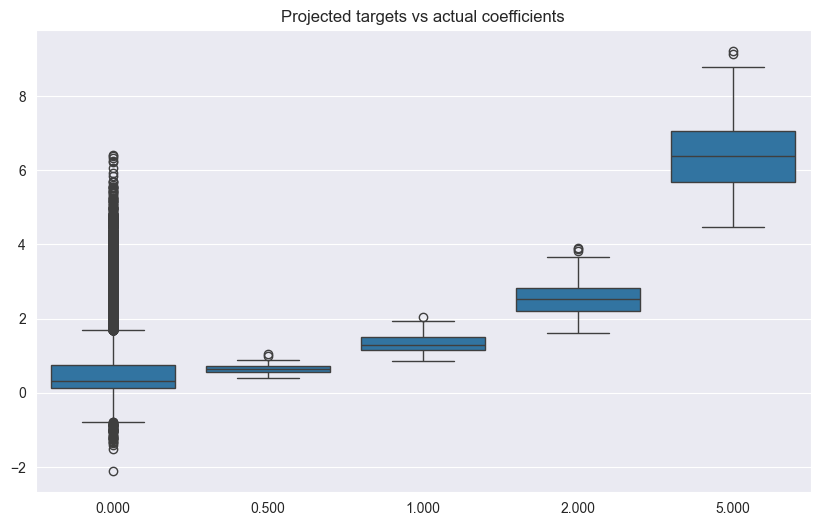

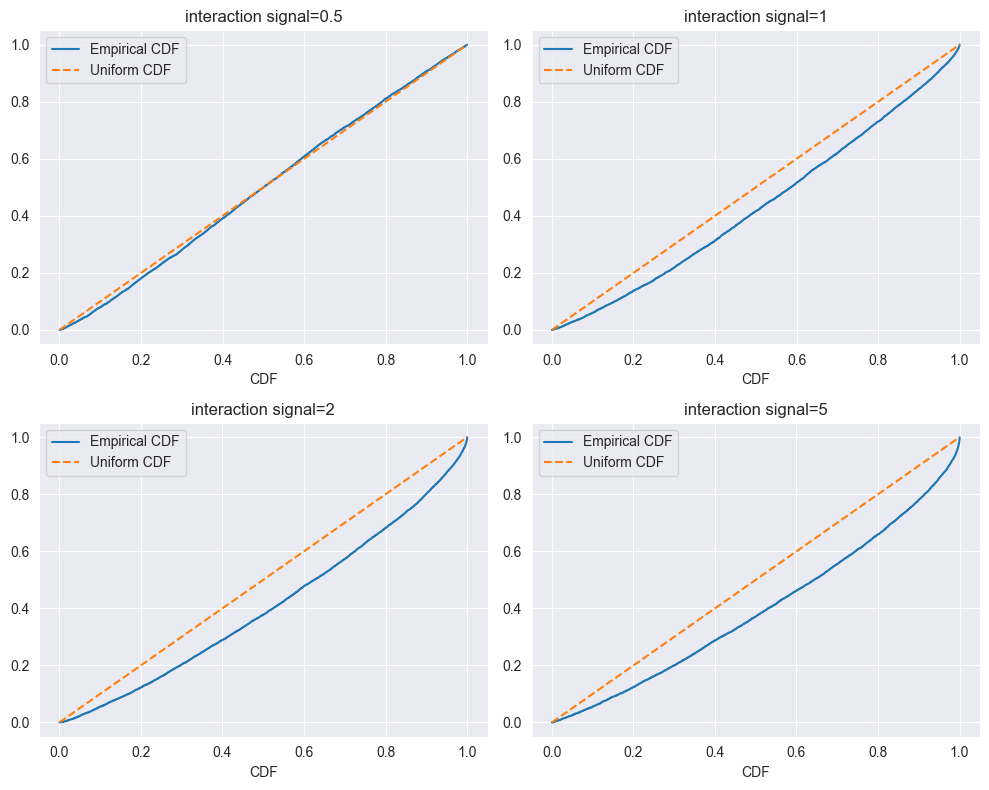

In [23]:
plot_pvals_targets(gammas_list, targets_list, p_values_ll, SNR_list=[0.5, 1, 2, 5])

# Plot Values of Projected Interaction Parameters with Nonlinear Function

In [24]:
def naive_project_vs_pvals_nl():
    s_inter = 5
    p_nl = 20
    gammas_list = []
    targets_list = []
    p_values_ll = []
    p_values_ll_MLE = []
    const = group_lasso.gaussian
    
    for sig in [0.5, 1, 2, 5]:
        p_values_sig = []
        for i in range(50):
            (design, data_interaction, Y, Y_mean, data_combined,
             groups, active, active_inter_adj, active_inter_list, gamma) \
                = generate_gaussian_instance_nonlinear_interaction_simple(n=500,
                                                                 p_nl=p_nl,
                                                                 rho=0.6, full_corr=True,
                                                                 rho_noise=0.6,
                                                                 SNR = 1,
                                                                 nknots = 6, degree = 2,
                                                                 interaction_signal=sig,
                                                                 random_signs=False,
                                                                 scale=True,
                                                                 center=True,structure='weakhierarchy',
                                                                 s_interaction=s_inter,
                                                                 intercept=True,
                                                                 return_gamma=True)
        
            while True:
                coverages, lengths, selected_inter, p_values, targets, nulltargets \
                    = naive_projected_inter(X=design, Y=Y, groups=groups,
                                        Y_mean=Y_mean, const=const,
                                        n_features=20, interactions=data_interaction,
                                        weight_frac=0.5, level=0.9, mode='allpairs',
                                        solve_only=False, continued=False,
                                        parallel=False, p_val=True, intercept=True,
                                        active_inter_list=active_inter_list)
                
                nzeros = len(nulltargets)
                assert nzeros == p_nl*(p_nl-1)/2 - s_inter
                
                if coverages is not None:
                    gammas_list.extend([gamma]*s_inter)
                    gammas_list.extend([0]*nzeros)
                    targets_list.extend(list(targets))
                    targets_list.extend(list(nulltargets))
                    p_values_sig.extend(list(p_values))
                    break
        p_values_ll.append(p_values_sig)
    
    return gammas_list, targets_list, p_values_ll

In [25]:
gammas_list_nl, targets_list_nl, p_values_ll_nl = naive_project_vs_pvals_nl()

Equally spaced quantile knots used.
14.0
Naive Selection Size: 10
Equally spaced quantile knots used.
16.0
Naive Selection Size: 29
Equally spaced quantile knots used.
15.0
Naive Selection Size: 22
Equally spaced quantile knots used.
15.0
Naive Selection Size: 11
Equally spaced quantile knots used.
16.0
Naive Selection Size: 12
Equally spaced quantile knots used.
15.0
Naive Selection Size: 17
Equally spaced quantile knots used.
16.0
Naive Selection Size: 11
Equally spaced quantile knots used.
14.0
Naive Selection Size: 29
Equally spaced quantile knots used.
12.0
Naive Selection Size: 9
Equally spaced quantile knots used.
14.0
Naive Selection Size: 42
Equally spaced quantile knots used.
14.0
Naive Selection Size: 33
Equally spaced quantile knots used.
14.0
Naive Selection Size: 17
Equally spaced quantile knots used.
15.0
Naive Selection Size: 35
Equally spaced quantile knots used.
15.0
Naive Selection Size: 11
Equally spaced quantile knots used.
15.0
Naive Selection Size: 24
Equally spa

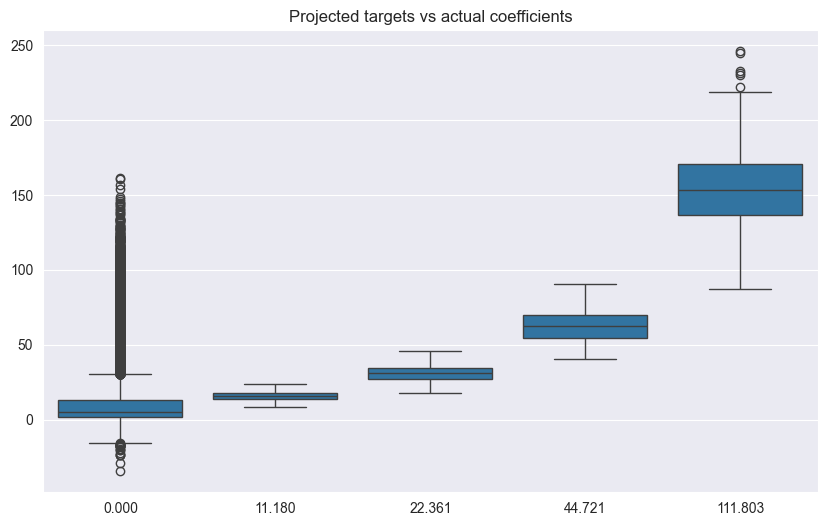

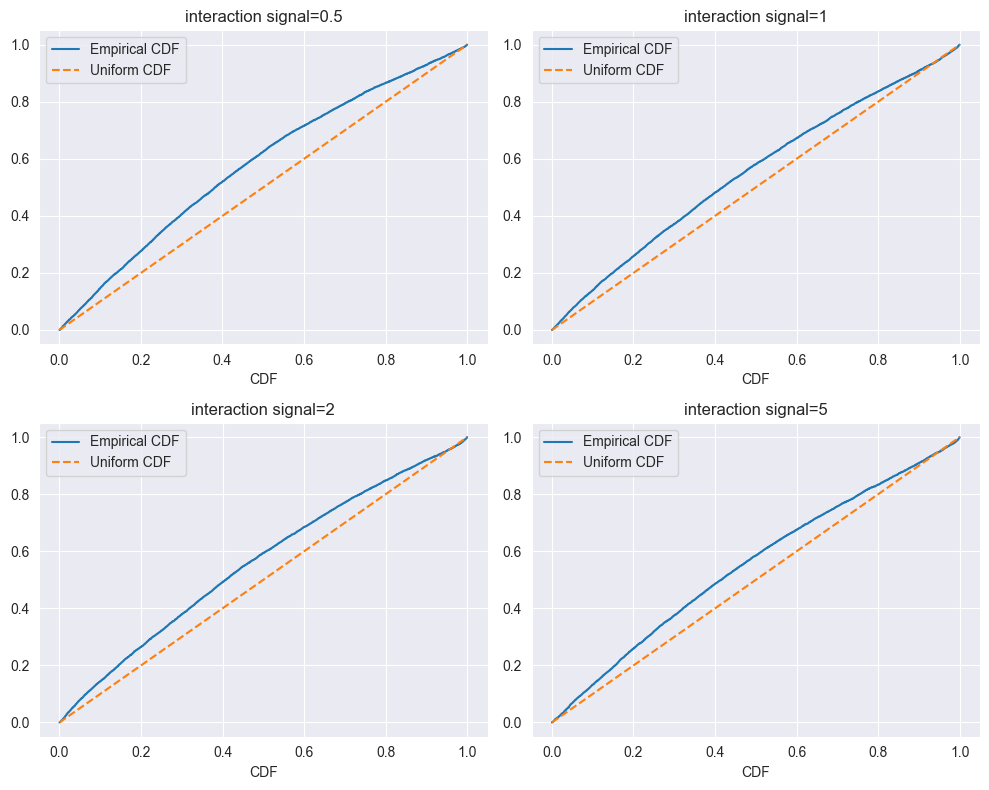

In [26]:
plot_pvals_targets(gammas_list_nl, targets_list_nl, p_values_ll_nl,
                   SNR_list=[0.5, 1, 2, 5])